# 11752 - Aprendizaje automático: Práctica final del bloque 1 
### Código fuente: https://github.com/alexvazquez94/11752-final-project
### Autor: Alejandro Vázquez Llabrés
### Fecha: 17/02/2021


## 1. Introducción
En esta práctica aplicaremos algunos de los conceptos y técnicas vistos en la asignatura *Aprendizaje automático* del *Máster en Sistemas Inteligentes* de la *UIB* para resolver el siguiente problema:
* Dado un conjunto de datos que contiene información sobre diferentes alojamientos que se ofertan a través de la plataforma *Airbnb* en la isla de Mallorca, encontrar un modelo que sea capaz de realizar una estimación del precio de un alojamiento en base a sus características.
Para resolver dicho problema, construiremos y aplicaremos diferentes modelos de regresión debido a que el resultado a obtener por las predicciones es un valor numérico continuo.


## 2. Carga, preprocesamiento de los datos y selección de características
A continuación, cargaremos el conjunto de datos a analizar y aplicaremos diferentes acciones sobre dichos datos. Dichas acciones tienen el objetivo de disponer de un conjunto de datos válido y, en la medida de lo posible, óptimo para poder construir un modelo de regresión con el que poder afrontar el problema de esta práctica.

### Librerías y definición de funciones

In [1]:
# Las librerías pandas y numpy para el tratamiento de datos
import pandas as pd
import numpy as np

# Las librerías seaborn y matplotlib para realizar gráficas
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Librerías para realizar cálculos
import math

# Otras librerías
import time
from datetime import datetime

# Sci-kit
from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit, cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Instala (si es necesario) y carga la librería xgboost
import sys
!{sys.executable} -m pip install xgboost
import xgboost as xgb
from xgboost import plot_importance


seed = 42
np.random.seed(seed) # Establecemos semilla de aleatoriedad

# Definimos función que muestra las dimensiones de un dataframe y un resumen sobre
# sus diferentes columnas
def show_dataframe_info(df):
    print("------------------------------------------------------------------------")
    print("---------------------    Información del dataset    --------------------")
    print("------------------------------------------------------------------------")
    print(str(df.shape[0]) + " filas (muestras) y " + str(df.shape[1]) \
          + " columnas (características)\n")
    df.info()

### Carga del conjunto de datos

In [2]:
# Cargamos los datos
raw_data = pd.read_csv('data/airbnb.csv')
df = raw_data.copy() # Trabajaremos con una copia

# Mostramos información general sobre el dataset para hacernos una idea
show_dataframe_info(df)

------------------------------------------------------------------------
---------------------    Información del dataset    --------------------
------------------------------------------------------------------------
17608 filas (muestras) y 74 columnas (características)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17608 entries, 0 to 17607
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            17608 non-null  int64  
 1   listing_url                                   17608 non-null  object 
 2   scrape_id                                     17608 non-null  int64  
 3   last_scraped                                  17608 non-null  object 
 4   name                                          17607 non-null  object 
 5   description                                   17393 non-null  object 
 6   neighborhoo

In [3]:
# Mostramos los 5 primeros registros
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11547,https://www.airbnb.com/rooms/11547,20200919153121,2020-09-21,My home at the beach,"Sun, joy, relax, quality, beach & peace.<br />...",NaN,https://a0.muscache.com/pictures/494126/8c151b...,42942,https://www.airbnb.com/users/show/42942,...,10.0,10.0,10.0,NaN,f,1,1,0,0,0.93
1,100831,https://www.airbnb.com/rooms/100831,20200919153121,2020-09-21,HOUSE IN MALLORCA - WiFi(ET-3045),<b>The space</b><br />House situated in a quie...,NaN,https://a0.muscache.com/pictures/675527/72b329...,529151,https://www.airbnb.com/users/show/529151,...,10.0,10.0,10.0,ETV-3045,t,1,1,0,0,1.47
2,105891,https://www.airbnb.com/rooms/105891,20200919153121,2020-09-20,VILLAGE HOUSE WITH POOL: IDEAL FOR FAMILIES,The house is a street on the outskirts of the ...,The village's population does not reach two th...,https://a0.muscache.com/pictures/1036816/f36ce...,549192,https://www.airbnb.com/users/show/549192,...,10.0,9.0,10.0,ETV/6127,t,2,2,0,0,0.14
3,106833,https://www.airbnb.com/rooms/106833,20200919153121,2020-09-20,Villa with a big pool in Mallorca,<b>The space</b><br />This is a restored old b...,NaN,https://a0.muscache.com/pictures/710218/98134c...,551974,https://www.airbnb.com/users/show/551974,...,10.0,9.0,9.0,ET/1961,f,1,1,0,0,0.09
4,130669,https://www.airbnb.com/rooms/130669,20200919153121,2020-09-20,Room great apartment,Located in a residential neighbourhood and 10m...,"Located in the center of the city, within minu...",https://a0.muscache.com/pictures/866653/58dc48...,643065,https://www.airbnb.com/users/show/643065,...,NaN,NaN,NaN,NaN,t,2,0,2,0,NaN


### Limpieza y preprocesamiento de los datos
Como se puede apreciar, hay algunas columnas con número muy elevado de elementos nulos, de manera que no nos serán de utilidad. Dichas columnas son:

* *neighborhood_overview* 
* *host_neighbourhood* 
* *neighbourhood*
* *neighbourhood_group_cleansed*
* *bathrooms*
* *calendar_updated*

Es bastante curioso que el campo que indica el número de baños únicamente tenga valores nulos, ya que dicho valor a priori sí puede parecer relevante para nuestro problema. No obstante, si vemos el contenido de la variable *bathrooms_text*, podemos ver que sí disponemos de dicha información:

In [4]:
# ¿Qué hay en la variable bathrooms_text?
df['bathrooms_text'].head()

0     1 bath
1    3 baths
2    2 baths
3     1 bath
4     1 bath
Name: bathrooms_text, dtype: object

Como vemos, a partir de la columna *bathrooms_text* podemos obtener el número de baños del alojamiento.

Por otra parte, podemos ver que hay columnas que no nos serán de utilidad porque:
* No aportan información relevante sobre el alojamiento:
    - Identificador interno del alojamiento y su url.
    - Información sobre el *scrapping* de los datos.
    - Información calculada sobre la cantidad de otros alojamientos del mismo *host*.
* Podrían aportar información, pero requeriría aplicar tratamientos costosos y/o técnicas más avanzadas (PE: procesamiento de texto o de imágenes). En este punto, encontramos campos de descripción como *description*, *host_about* o *picture_url*.
* Aportan información redundante.

Además, también cabe a destacar que algunas de las variables no son del tipo correcto:
* *price*, dado que tiene carácteres no numéricos como el símbolo *\\$*.
* Campos que indican un valor booleano, los cuales tienen los valores *t/f*.

Teniendo en cuenta todo lo anterior, en este apartado haremos la siguiente pre-selección de características:

In [5]:
# Obtenemos el número de baños a partir del campo bathrooms_text
df['bathrooms'] = df.bathrooms_text.str.extract('(\d+)').astype(float)

# Modificamos los campos booleanos con valores t/f con los valores 1/0
df = df.replace({'t': 1, 'f': 0})

# Eliminamos los símbolos $ y , del campo price y lo convertimos a numérico
df['price'] = df['price'].str.replace("$","").str.replace(",","").astype(float)

# Seleccionamos columnas que, a priori, pueden ser relevantes 
df = df[['host_is_superhost',
         'host_has_profile_pic',
         'neighbourhood_cleansed',
         'latitude',
         'longitude',
         'property_type',
         'room_type',
         'accommodates',
         'beds',
         'bedrooms',
         'bathrooms',
         'amenities',
         'minimum_nights',
         'maximum_nights',
         'availability_365',
         'number_of_reviews',
         'review_scores_value',
         'license',
         'price']]

A continuación, vamos a comprobar si merece la pena o no conservar todas las variables que hemos seleccionado anteriormente.

In [6]:
# Cantidad de alojamientos con 'superhost'
df.host_is_superhost.value_counts()

0.0    14216
1.0     3390
Name: host_is_superhost, dtype: int64

In [7]:
# Cantidad de alojamientos en los que el host tiene foto de perfil
df.host_has_profile_pic.value_counts()

1.0    17561
0.0       45
Name: host_has_profile_pic, dtype: int64

In [8]:
# Alojamientos sin licencia?
df.license.isnull().sum()

6177

Como se puede observar, aproximadamente un 35% de los alojamientos dispone de licencia, de manera que mantenemos esta característica. No obstante, como lo que tenemos son códigos de licencia, tendremos que modificarlo por un valor booleano que indique si un alojamiento tiene licencia. Por otra parte, también mantendremos el campo que indica si un anfitrión tiene la consideración de *superhost*, ya que representa aproximadamente el 20% de los alojamientos son de este tipo de anfitriones. Sin embargo, eliminaremos la variable *host_has_profile_pic*, ya que no tiene suficiente varianza.

In [9]:
# Si tiene licencia -> 1, en caso contrario -> 0
df.loc[df.license.isnull() == False, 'license'] = 1
df.loc[df.license.isnull(), 'license'] = 0
df['license'] = df.license.astype(float)

# Eliminamos la columna host_has_profile_pic, ya que es irrelevante en este caso
df.drop(columns=['host_has_profile_pic'], inplace=True)

A continuación, vamos a ver, cuántos valores nulos tenemos en cada característica.

In [10]:
df.isnull().sum()

host_is_superhost            2
neighbourhood_cleansed       0
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
beds                        97
bedrooms                   275
bathrooms                   23
amenities                    0
minimum_nights               0
maximum_nights               0
availability_365             0
number_of_reviews            0
review_scores_value       6659
license                      0
price                        0
dtype: int64

Como vemos, los campos con valores nulos son:
* *host_is_superhost*: En este caso, interpretaremos que la abscencia de valor indica que no es *superhost*.
* *bathrooms*: En este caso, interpretamos que tienen 1 baño, ya que en *bathroom_text* había valores del tipo "half-bathroom".
* *beds*, *bedrooms* y *review_scores_value*: En este caso, no penalizaremos tanto la abscencia de valor e indicaremos el valor medio de cada tipo de columna, ya que pueden no haberlo introducido por error o por considerarlo redundante.

In [11]:
df['host_is_superhost'].fillna(0, inplace=True)
df['bathrooms'].fillna(0, inplace=True)

for col in ['review_scores_value', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)  

A continuación, vamos a analizar y tratar los campos relativos a las *reviews* de los alojamientos.

In [12]:
df.number_of_reviews.describe() # Obtenemos datos estadísticos 

count    17608.000000
mean        11.677647
std         27.348385
min          0.000000
25%          0.000000
50%          2.000000
75%         10.000000
max        520.000000
Name: number_of_reviews, dtype: float64

In [13]:
df.review_scores_value.describe()

count    17608.000000
mean         9.113585
std          0.814227
min          2.000000
25%          9.000000
50%          9.000000
75%         10.000000
max         10.000000
Name: review_scores_value, dtype: float64

Como vemos el número medio de *reviews* es de aproximadamente 12 valoraciones y oscila entre 0 y 520. Por otra parte, las puntuaciones oscilan entre 2 y 10, con un valor medio de aproximadamente 9. A continuación, vamos a crear una nueva columna que recoja la información de estas dos columnas, es decir, presente una puntuación que tenga en cuenta el número total de valoraciones. Para conseguir dicho objetivo, me he pasado en la solución propuesta en:

https://math.stackexchange.com/questions/942738/algorithm-to-calculate-rating-based-on-multiple-reviews-using-both-review-score

In [14]:
# Definimos la fórmula a aplicar para calcular la nueva puntuación. Esta
# puntuación tiene en cuenta el número de reviews
def get_score(review_score, n_of_reviews): 
    k_points = 10
    k_mean_n_reviews = 13
    
    return review_score + k_points * (1 - math.exp(-n_of_reviews/(k_mean_n_reviews*2)))


# Creamos nueva columna aplicando dicha fórmula
df['score'] = df.apply(lambda row: get_score(row['review_scores_value'], 
                                             row['number_of_reviews']), axis = 1)

# Ya no necesitamos las variables anteriores
df.drop(columns=['review_scores_value', 'number_of_reviews'], inplace=True)

Por otra parte, cabe a destacar que convendría agrupar las diferentes categorías de propiedad, ya que hay demasiadas. Unificar dichas categorías en categorías más amplias como casa, apartamento o chalet puede ser beneficioso para nuestro modelo.

In [15]:
# Obtemos la cantidad de muestras para cada tipo de propiedad
df.property_type.value_counts()

Entire villa                   4878
Entire house                   4823
Entire apartment               3259
Entire cottage                  880
Entire chalet                   655
                               ... 
Shared room in guesthouse         1
Private room in earth house       1
Entire vacation home              1
Shared room in igloo              1
Entire resort                     1
Name: property_type, Length: 74, dtype: int64

In [16]:
# Para cada fila del dataframe
for index, row in df.iterrows():
    # Es un apartamento
    if 'APARTMENT' in row['property_type'].upper() or \
       'ESTUDIO' in row['property_type'].upper() or \
       'STUDIO' in row['property_type'].upper() or \
       'LOFT' in row['property_type'].upper():
        df.iloc[index, df.columns.get_loc("property_type")] = 'Apartamento'
    
    # Es una casa
    elif 'HOUSE' in row['property_type'].upper() or \
         'CASA' in row['property_type'].upper() or \
         'BUNGALOW' in row['property_type'].upper():
        df.iloc[index, df.columns.get_loc("property_type")] = 'Casa'
    
    # Es un chalet/villa/casa de campo
    elif 'CHALET' in row['property_type'].upper() or \
         'VILLA' in row['property_type'].upper() or \
         'COTTAGE' in row['property_type'].upper():
        df.iloc[index, df.columns.get_loc("property_type")] = 'Chalet_Villa'
 
    # Otros tipos minoritarios de propiedades
    else:
        df.iloc[index, df.columns.get_loc("property_type")] = 'Otros'
        
print("------------------    Tipos de propiedad   ------------------")
df.property_type.value_counts()

------------------    Tipos de propiedad   ------------------


Chalet_Villa    6542
Casa            5817
Apartamento     4112
Otros           1137
Name: property_type, dtype: int64

In [17]:
print("------------------    Tipos de habitación   ------------------")
df.room_type.value_counts()

------------------    Tipos de habitación   ------------------


Entire home/apt    15770
Private room        1589
Hotel room           230
Shared room           19
Name: room_type, dtype: int64

En cuanto al tipo de habitación, podemos ver que mayoritariamente se alquilan propiedades enteras. A continuación, vamos a tratar la variable *amenities* (comodidades).

In [18]:
df.amenities.unique() # Mostramos algunas de las combinaciones de comodidades

array(['["Oven", "Wifi", "Coffee maker", "Dishes and silverware", "Essentials", "Kitchen", "TV", "Cooking basics", "Refrigerator", "Shampoo", "Microwave", "Pool", "Beachfront", "Free parking on premises", "Free street parking", "Air conditioning", "Host greets you", "Elevator", "Hot water", "Patio or balcony", "Stove", "Washer", "Heating"]',
       '["First aid kit", "Hair dryer", "Iron", "Washer", "Free street parking", "Air conditioning", "Essentials", "Hangers", "Smoke alarm", "Indoor fireplace", "Carbon monoxide alarm", "Kitchen", "Wifi", "Laptop-friendly workspace", "TV", "Cable TV", "Coffee maker", "Dishes and silverware", "Fire extinguisher", "Shampoo"]',
       '["Smoke alarm", "Oven", "Wifi", "Garden or backyard", "Coffee maker", "Dishes and silverware", "Fire extinguisher", "First aid kit", "Essentials", "Dishwasher", "Carbon monoxide alarm", "Kitchen", "TV", "Cooking basics", "Refrigerator", "Microwave", "Pool", "Hair dryer", "Iron", "Crib", "High chair", "Air conditioning",

Como podemos apreciar, existe un número elevado de comodidades, de manera que sería difícil (y probablemente inútil) tratarlos todos. Por lo tanto, en este caso vamos a seleccionar, de manera subjetiva, cuales pueden ser las comodidades que puedan influir en el precio final del alojamiento. Además, de la misma manera que en el caso de los tipos de propiedad, vamos formar nuevas categorías algo más genéricas para facilitar el trabajo a nuestro modelo. Concretamente, hemos definido las variables:
* *internet*: Indica si el alojamiento dispone de conexión a Internet.
* *outdoor*: Indica si el alojamiento dispone de terraza, patio, etc.
* *pool*: Indica si el alojamiento tiene piscina o jacuzzi.
* *air_conditioning*: Indica si el alojamiento tiene aire acondicionado.
* *private_entrance*: Indica si el acceso al alojamiento es privado (está separado).
* *parking*: Indica si el alojamiento tiene parking.
* *breakfast*: Indica si sirven desayuno en el alojamiento.
* *greeting*: Indica si el anfitrión recibe a los huéspedes personalmente.

In [19]:
# Creamos las nuevas columnas, con valor 0 por defecto
df['internet'] = 0
df['outdoor'] = 0
df['pool'] = 0
df['air_conditioning'] = 0
df['private_entrance'] = 0
df['parking'] = 0
df['breakfast'] = 0
df['greeting'] = 0

for index, row in df.iterrows():
    if "INTERNET" in row['amenities'].upper() or \
       "WI-FI" in row['amenities'].upper() or \
       "ETHERNET" in row['amenities'].upper() or \
       "WIFI" in row['amenities'].upper():
        df.iloc[index, df.columns.get_loc("internet")] = 1
    
    if "OUTDOOR" in row['amenities'].upper() or \
       "GARDEN" in row['amenities'].upper() or \
       "TERRACE" in row['amenities'].upper() or \
       "PATIO" in row['amenities'].upper():
        df.iloc[index, df.columns.get_loc("outdoor")] = 1
        
    if "HOT TUB" in row['amenities'].upper() or \
       "POOL" in row['amenities'].upper():
        df.iloc[index, df.columns.get_loc("pool")] = 1
    
    if "AIR CONDITIONING" in row['amenities'].upper():
        df.iloc[index, df.columns.get_loc("air_conditioning")] = 1
    
    if "PRIVATE ENTRANCE" in row['amenities'].upper():
        df.iloc[index, df.columns.get_loc("private_entrance")] = 1
    
    if "PARKING" in row['amenities'].upper():
        df.iloc[index, df.columns.get_loc("parking")] = 1
    
    if "BREAKFAST" in row['amenities'].upper():
        df.iloc[index, df.columns.get_loc("breakfast")] = 1
        
    if "HOST GREETS YOU" in row['amenities'].upper():
        df.iloc[index, df.columns.get_loc("greeting")] = 1

# Ya no nos hace falta la columna original
df.drop(columns='amenities', inplace=True)

# Mostramos valores
print("------------------    Proporción verdadero / falso   ------------------")
print("Internet: "+ str(df.outdoor.value_counts()[1]) + " / " +\
      str(df.internet.value_counts()[0]) + "\n")
print("Exterior (jardín, patio, etc.): "+ str(df.outdoor.value_counts()[1]) + " / " +\
      str(df.internet.value_counts()[0]) + "\n")
print("Piscina/jacuzzi: "+ str(df.outdoor.value_counts()[1]) + " / " +\
      str(df.outdoor.value_counts()[0]) + "\n")
print("Aire acondicionado: "+ str(df.air_conditioning.value_counts()[1]) + " / " +\
      str(df.air_conditioning.value_counts()[0]) + "\n")
print("Entrada privada: "+ str(df.private_entrance.value_counts()[1]) + " / " +\
      str(df.private_entrance.value_counts()[0]) + "\n")
print("Parking: "+ str(df.parking.value_counts()[1]) + " / " +\
      str(df.parking.value_counts()[0]) + "\n")
print("Desayuno: "+ str(df.breakfast.value_counts()[1]) + " / " +\
      str(df.breakfast.value_counts()[0]) + "\n")
print("Recibimiento por parte del host: "+ str(df.greeting.value_counts()[1]) + " / " +\
      str(df.greeting.value_counts()[0]) + "\n")

# Mostramos cómo ha quedado nuestro dataframe por ahora
show_dataframe_info(df)

------------------    Proporción verdadero / falso   ------------------
Internet: 11003 / 1058

Exterior (jardín, patio, etc.): 11003 / 1058

Piscina/jacuzzi: 11003 / 6605

Aire acondicionado: 12584 / 5024

Entrada privada: 7641 / 9967

Parking: 13537 / 4071

Desayuno: 774 / 16834

Recibimiento por parte del host: 3885 / 13723

------------------------------------------------------------------------
---------------------    Información del dataset    --------------------
------------------------------------------------------------------------
17608 filas (muestras) y 24 columnas (características)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17608 entries, 0 to 17607
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_is_superhost       17608 non-null  float64
 1   neighbourhood_cleansed  17608 non-null  object 
 2   latitude                17608 non-null  float64
 3   longitude       

Finalmente, vamos a analizar la variable objetivo, el precio.

In [20]:
df.price.describe()

count    17608.000000
mean       244.383561
std        409.958169
min          0.000000
25%        110.000000
50%        179.000000
75%        275.000000
max      20736.000000
Name: price, dtype: float64

Como vemos, el precio medio de los alojamientos es de 244,38\\$ y oscila entre 0\\$ y 20736\\$. En cuanto a los alojamientos con precio 0, podemos eliminarlos, ya que únicamente nos aportarán ruido. Por otra parte, el hecho de que el precio máximo sea de 20736\\$ puede indicarnos la presencia de *outliers*. Para verlo más claro, vamos a dibujar algunas gráficas con el precio:

<AxesSubplot:xlabel='price'>

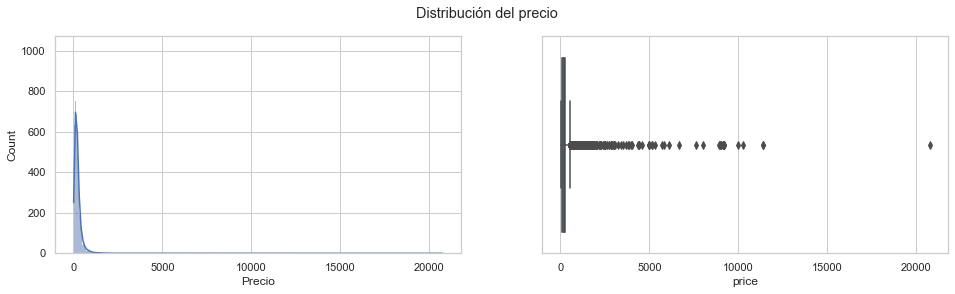

In [21]:
sns.set_theme(style="whitegrid") # Definimos estilo del grid

# Eliminamos precios igual a 0
df = df.loc[(df.price != 0)]
            
# Dibujamos figura
fig, axs = plt.subplots(ncols = 2, figsize = (16, 4))
fig.suptitle('Distribución del precio')

# Dibujamos histograma
sns.histplot(pd.Series(df["price"], name = 'Precio'), kde = True, ax = axs[0])

# Dibujamos boxplot
sns.boxplot(x=df["price"], ax = axs[1]) 

Como vemos, podemos confirmar la presencia de valores atípicos para el precio. Para mitigar este problema y así conseguir que los diferentes alojamientos sean más comparables entre sí, voy a eliminar los alojamientos con un precio mayor o igual a 400\\$. 

<AxesSubplot:xlabel='price'>

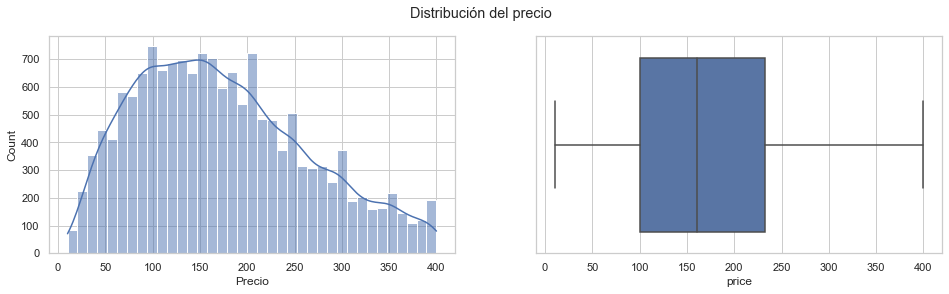

In [22]:
# Eliminamos muestras con precio a partir de 400$
df = df.loc[(df.price <= 400)]
          
# Dibujamos figura
fig, axs = plt.subplots(ncols = 2, figsize = (16, 4))
fig.suptitle('Distribución del precio')

# Dibujamos histograma
sns.histplot(pd.Series(df["price"], name = 'Precio'), kde = True, ax = axs[0])

# Dibujamos boxplot
sns.boxplot(x=df["price"], ax = axs[1]) 

Como podemos observar, la presencia de *outliers* respecto al precio se ha mitigado.

Una vez que ya hemos seleccionado y procesado las características con las que vamos a trabajar, podemos pasar a observar cómo estas impactan sobre el precio.

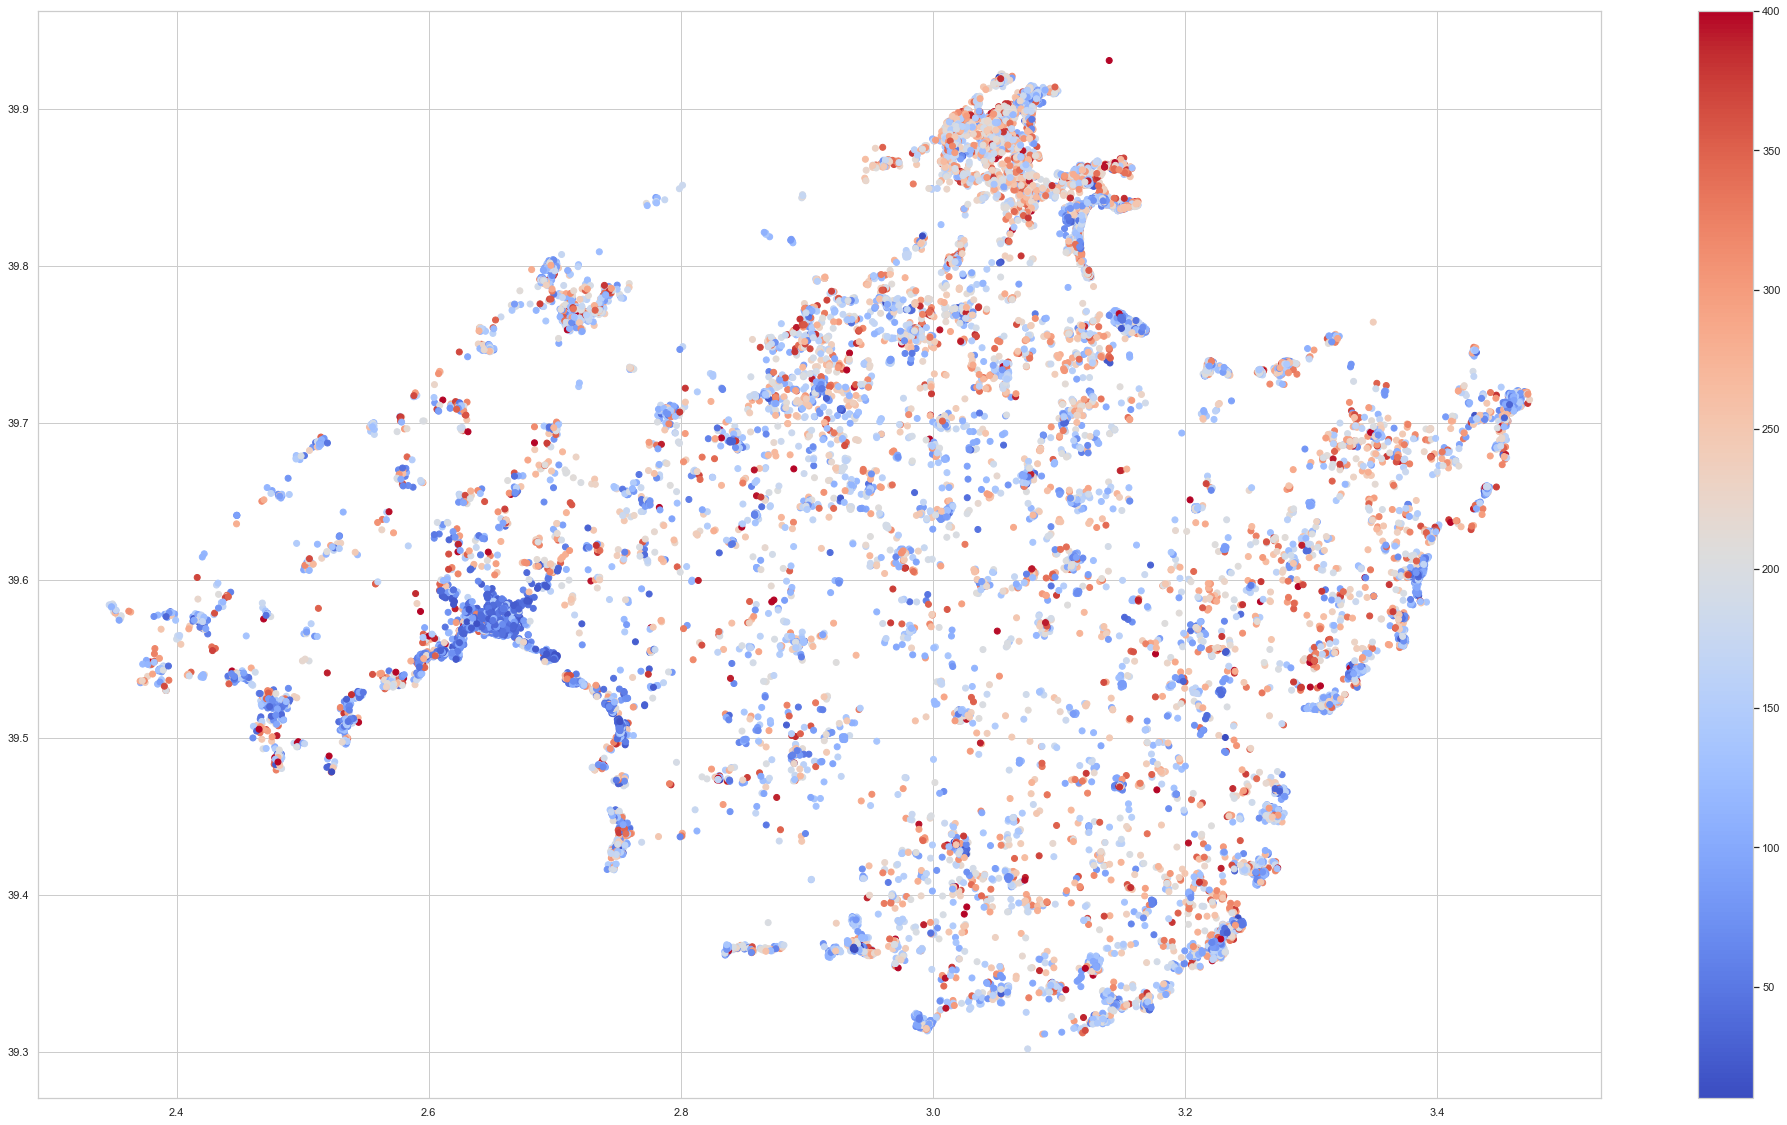

In [23]:
# Dibujamos mapa con el precio en función de la ubicación del alojamiento (x, y)
# Para ello, se utilizan las columnas longitude y latitude
plt.subplots(figsize=(35, 20))
plt.scatter(x=df.longitude, y=df.latitude, c=df.price, cmap='coolwarm')
plt.colorbar()
plt.show()

Como se puede observar, en la zona nord-este de la isla observamos una presencia mayor de alojamientos con precios elevados. Sin embargo, podemos observar puntos rojos de manera más dispersa prácticamente por toda la isla. En cuanto a Palma, cabe a destacar que sorprendentemente presenta la mayor concentración de alojamientos más asequibles. Este hecho se debe, probablemente, a que la cantidad de alojamientos es alta y a que se ofertan muchas viviendas del tipo "apartamento".

A continuación, vamos a ver cómo impacta el número de personas a las que puede albergar el alojamiento a su precio. Además, también realizaremos lo mismo para la variable *score*.

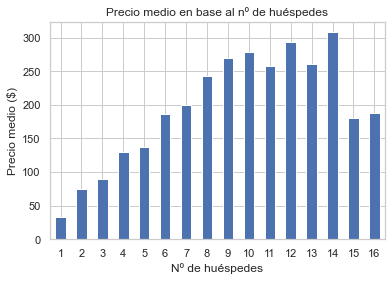

In [24]:
plt.figure()
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Precio medio en base al nº de huéspedes')
plt.xlabel('Nº de huéspedes')
plt.ylabel('Precio medio ($)')
plt.xticks(rotation=0)
plt.show()

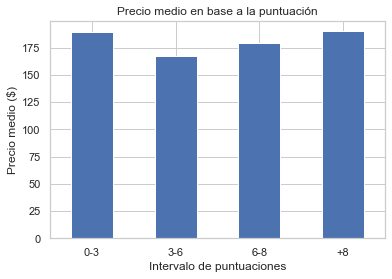

In [25]:
# Definimos intervalos 
df['score_group'] = pd.cut(df['score'],
                           bins=[0, 3, 6, 8, 10], 
                           labels=["0-3", "3-6", "6-8", "+8"])

# Dibujamos la gráfica
plt.figure()
df.groupby('score_group').price.median().plot(kind='bar')
plt.title('Precio medio en base a la puntuación')
plt.xlabel('Intervalo de puntuaciones')
plt.ylabel('Precio medio ($)')
plt.xticks(rotation=0)
plt.show()

# Ya no necesitamos el campo score group
df.drop(columns='score_group', inplace=True)

Como podemos observar, encontramos los precios medios más altos para los alojamientos con muy buenas puntuaciones o con muy malas puntuaciones. Este hecho probablemente se debe a que, normalmente al pagar un precio más elevado, los clientes tienden a ser más exigentes. No obstante, si antendemos al precio medio entre estos intervalos, no parece variar demasiado si sólo tenemos en cuenta esta característica.

### Transformación de las variables categóricas
A continuación, vamos a transformar las variables categóricas (PE: vecindario) a valores numéricos para que el modelo a pueda trabajar con ellas. Para ello, haremos uso de la función *get_dummies* de *pandas*, con la cual se aplica *One-hot encoding*.

In [26]:
df = pd.get_dummies(df)

### Detección y corrección de colinealidad
A continuación, vamos a estudiar si se da colinealidad/multicolinealidad entre las diferentes características seleccionadas, es decir, cuando una de las características es una combinación lineal de otras, teniendo una correlación fuerte. Si se da el caso, conviene eliminar algunas de las características afectadas, ya que pueden alterar el correcto funcionamiento de nuestro modelo.

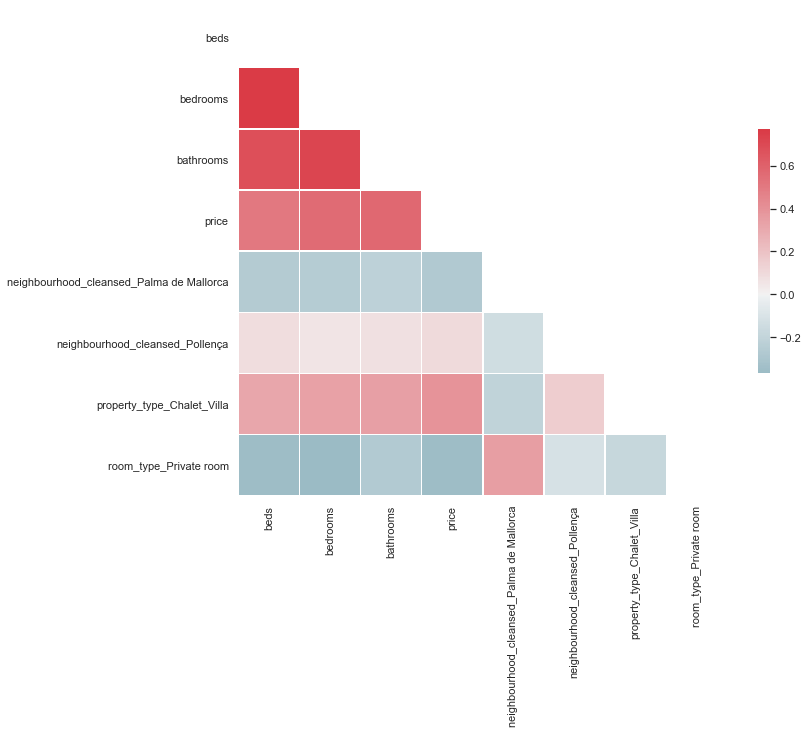

In [27]:
# Obtenemos matriz de correlación
corr = df.corr()

# Encontramos columnas a eliminar del gráfico, con correlaciones bajas
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if not any(abs(upper[column]) >= 0.5)]

# Eliminamos columnas  
plot_df = df.drop(to_drop, axis=1)

# Obtenemos de nuevo la matriz de correlación
corr = plot_df.corr()

# Generamos máscara para el triángulo superior de la matriz
mask = np.triu(np.ones_like(corr, dtype=bool))

# Definimos figura
f, ax = plt.subplots(figsize=(11, 9))

# Generamos mapa de calor divergente
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Dibujamos el mapa de calor aplicando la máscara
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, 
            vmax=corr[corr != 1.0].max().max());

Como podemos apreciar, como ya sospechabamos anteriormente, las características *beds*, *bedrooms* y *bathrooms* están altamente relacionadas entre sí y presentan multicolinealidad. Por lo tanto, conviene eliminar dichas columnas.

In [28]:
# Eliminamos columnas que presentan multicolinealidad 
df.drop(columns=['beds', 'bedrooms', 'bathrooms'], inplace=True)

Por otra parte, también hemos podido apreciar una correlación notable entre algunas variables y el precio. A continuación, vamos a mostrar las características que presentan una mayor correlación con el precio:

In [29]:
# Calculamos correlación con el precio
corr = df[df.columns[0:]].corr()['price'][:]

# Mostramos los resultados ordenados (si pasan de cierto umbral)
corr[np.abs(corr) > 0.3].sort_values(ascending=False)

price                         1.000000
accommodates                  0.618173
pool                          0.432232
property_type_Chalet_Villa    0.396764
room_type_Entire home/apt     0.340776
license                       0.329195
score                        -0.319990
room_type_Private room       -0.354869
property_type_Apartamento    -0.400947
Name: price, dtype: float64

Como se puede observar, la variables *accommodates*, *pool*, *property_type_Chalet_Villa* y *property_type_Apartamento* presentan correlaciones importantes con el precio.

### Obtención de los conjuntos de entrenamiento y test

In [30]:
# Separamos variables dependientes de independientes
X = df.drop('price', axis=1)
y = df.price

# Obtenemos los conjuntos de entrenamiento y test, con proporción 75-25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

# Aplicamos escalado estándar de las columnas predictoras
ss = StandardScaler()

X_train = pd.DataFrame(ss.fit_transform(X_train), columns=list(X_train.columns))
X_test = pd.DataFrame(ss.fit_transform(X_test), columns=list(X_test.columns))
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# Transformamos tipos float a int
X_train[X_train.select_dtypes(include='float64').columns] = X_train[X_train.select_dtypes(include='float64').columns].astype(int)
X_test[X_test.select_dtypes(include='float64').columns] = X_test[X_test.select_dtypes(include='float64').columns].astype(int)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Aplicamos escalado Min-Max sobre la variable objetivo (precio)
mms = MinMaxScaler()
y_train = mms.fit_transform(pd.DataFrame(y_train))
y_test = mms.fit_transform(pd.DataFrame(y_test))
y_scaled = mms.fit_transform(pd.DataFrame(y))

### Reducción de dimensiones

In [32]:
# Realizamos un grid search para ver si podemos reducir la dimensionalidad
# haciendo uso de análisis de componentes principales (PCA)
param_grid = {'n_components': range(df.shape[1])}
pca = PCA()

# Con n_jobs = -1 indicamos que se ejecute en paralelo haciendo uso de los 
# diferentes núcleso/procesadores
gs_pca = GridSearchCV(pca, param_grid, n_jobs=-1)
gs_pca.fit(X_train)

# Mostramos resultado
print("Mejor combinación: "+str(gs_pca.best_params_['n_components']), 'componentes')

Mejor combinación: 74 componentes


C:\Users\aleja\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


Como vemos, el número de variables no se ha reducido prácticamente nada. Por este motivo, decidimos no aplicar *PCA*.

## 3. Obtención del modelo
Una vez realizados todos los tratamientos y consideraciones oportunas, ya podemos pasar a implementar el modelo. Concretamente, probaremos con los siguientes modelos de *sci-kit*:
* *LinearRegression*: modelo lineal base sobre el que empezaremos a realizar pruebas.
* *DecisionTreeRegressor* (árboles de decisión).
* *RandomForestRegressor*.
* *GradientBoostingRegressor*.

Por otra parte, también probaremos con el modelo *XGBRegressor* (*Extreme Gradient Boosting*), el cual encontramos en la librería *xgboost*. Después de realizar una búsqueda a través de Internet, hemos visto que era ampliamente utilizado para resolver problemas similares (PE: https://towardsdatascience.com/predicting-airbnb-prices-with-machine-learning-and-location-data-5c1e033d0a5a). Por lo tanto, hemos decidido probar también con este modelo.

Por otra parte, cabe a destacar que utilizaremos las siguientes métricas:
* Error cuadrático medio (*RMSE*).
* Error medio absoluto (*MAE*): Respecto a esta métrica cabe a destacar que no tiene en cuenta la dirección del error, por lo que puede ser interesante aplicarla en este caso.
* Coeficiente de determinación (*R2*).

### Definición de funciones

In [50]:
# Se encarga de, dado un modelo y unos conjuntos de entrenamiento/test,
# entrenar el modelo y validarlo en base a las métricas MSE, MAE y R**2
def predict(model, X_train, y_train, X_test, y_test, scaler):
    # Entrenamos el modelo
    model.fit(X_train, y_train)
    
    # Obtenemos predicciones de entrenamiento y test
    train_pred = model.predict(X_train) 
    test_pred = model.predict(X_test)
    
    # Como hemos aplicado escalado, tenemos que revertirlo para disponer
    # de los valores reales
    train_price = scaler.inverse_transform(pd.DataFrame(y_train))
    train_pred_price = np.round(scaler.inverse_transform(pd.DataFrame(train_pred)), 3)
    test_price = scaler.inverse_transform(pd.DataFrame(y_test))
    test_pred_price = np.round(scaler.inverse_transform(pd.DataFrame(test_pred)), 3)
     
    # Calculamos diferencia y construimos dataframe con los resultados
    dif = np.round(abs(np.subtract(test_price, test_pred_price)), 2)
    df_pred = pd.DataFrame(np.hstack((test_price, test_pred_price, dif)), 
                           columns=['Precio', 'Precio predicho', 'Diferencia'])
    
    # Calculamos y mostramos los valores obtenidos para las métricas RMSE, MAE y R**2
    print("RMSE (entrenamiento):", round(np.sqrt(mean_squared_error(y_train, train_pred)), 4))
    print("RMSE (test):", round(np.sqrt(mean_squared_error(y_test, test_pred)), 4))
    print("MAE (entrenamiento)", round(mean_absolute_error(train_price, train_pred_price), 4))
    print("MAE (test):", round(mean_absolute_error(test_price, test_pred_price), 4))
    print("\nR2 (entrenamiento):", round(r2_score(y_train, train_pred), 4))
    print("R2 (test):", round(r2_score(y_test, test_pred), 4))
    print("\n")
    
    return model, df_pred


# Realiza un grid-search para encontrar la mejor combinación de parámetros
def grid_search(model, param_grid, X_train, y_train):
    # n_jobs = -1 para posibilitar paralelización
    gs = GridSearchCV(model, param_grid, n_jobs=-1) 
    gs.fit(X_train, y_train)
    
    print("Mejores parámetros: ", gs.best_params_)
    
    return gs.best_params_

# Aplica validación cruzada sobre el modelo 
def get_cv_scores(model, X, y, cv=5):
    print("--------   Puntuaciones tras la validación cruzada:    --------")
    cv = ShuffleSplit(n_splits=cv, test_size=0.25, random_state=seed)
    scores = cross_validate(model, X, y, cv=cv,
                            scoring=('neg_root_mean_squared_error', 
                                     'neg_mean_absolute_error', 
                                     'r2'),
                            return_train_score=True)
    
    return pd.DataFrame.from_dict(scores, orient='index')

In [40]:
X_scaled = pd.DataFrame(ss.fit_transform(X), columns=list(X.columns))

### LinearRegression

In [46]:
model = LinearRegression()

# Entrenamos y evaluamos el modelo
lr_reg, lr_pred = predict(model, 
                           X_train, y_train.ravel(), 
                           X_test, y_test.ravel(),
                           mms)

# Aplicamos valicación cruzada y mostramos valores medios
lr_score = get_cv_scores(model, X_scaled, y_scaled.ravel())
lr_score.mean(axis=1)

RMSE (entrenamiento): 0.1626
RMSE (test): 34511922897.0285
MAE (entrenamiento) 49.0462
MAE (test): 4111141487208.9463

R2 (entrenamiento): 0.5073
R2 (test): -2.2631555363604447e+22


--------   Puntuaciones tras la validación cruzada:    --------


fit_time                             0.033196
score_time                           0.003192
test_neg_root_mean_squared_error    -0.158093
train_neg_root_mean_squared_error   -0.156751
test_neg_mean_absolute_error        -0.121190
train_neg_mean_absolute_error       -0.120131
test_r2                              0.529689
train_r2                             0.540378
dtype: float64

In [47]:
lr_pred.head(10) # Mostramos algunas de las predicciones

,Precio,Precio predicho,Diferencia
0,109.0,1.774640e+02,6.846000e+01
1,59.0,1.408890e+02,8.189000e+01
2,19.0,4.441398e+13,4.441398e+13
3,151.0,1.394859e+11,1.394859e+11
4,226.0,2.332450e+02,7.240000e+00
5,357.0,2.599660e+02,9.703000e+01
6,180.0,1.340410e+02,4.596000e+01
7,150.0,1.564510e+02,6.450000e+00
8,111.0,2.028100e+02,9.181000e+01
9,397.0,2.484610e+02,1.485400e+02


Como era de esperar, los resultados obtenidos no son buenos para ninguna de las métricas. A continuación, probaremos con otros modelos.

### DecisionTreeRegressor

In [51]:
model = DecisionTreeRegressor()
params = {'criterion': ['mse', 'mae'], 'splitter': ['random', 'best']}
dtr_params = grid_search(model, params, X_train, y_train)

# Entrenamos y validamos el modelo 
model = DecisionTreeRegressor(criterion=dtr_params['criterion'],
                              splitter=dtr_params['splitter'])
dtr_reg, dtr_pred = predict(model,
                            X_train, y_train.ravel(), 
                            X_test, y_test.ravel(),
                            mms)

# Aplicamos valicación cruzada y mostramos valores medios
dtr_score = get_cv_scores(model, X_scaled, y_scaled.ravel())
dtr_score.mean(axis=1)

Mejores parámetros:  {'criterion': 'mse', 'splitter': 'random'}
RMSE (entrenamiento): 0.0625
RMSE (test): 0.2009
MAE (entrenamiento) 9.7425
MAE (test): 56.7736

R2 (entrenamiento): 0.9272
R2 (test): 0.2334


--------   Puntuaciones tras la validación cruzada:    --------


fit_time                             0.115108
score_time                           0.006312
test_neg_root_mean_squared_error    -0.203344
train_neg_root_mean_squared_error   -0.002351
test_neg_mean_absolute_error        -0.146556
train_neg_mean_absolute_error       -0.000050
test_r2                              0.221941
train_r2                             0.999894
dtype: float64

In [53]:
dtr_pred.head(10) # Mostramos algunas de las predicciones

,Precio,Precio predicho,Diferencia
0,109.0,104.000,5.00
1,59.0,88.000,29.00
2,19.0,38.333,19.33
3,151.0,285.000,134.00
4,226.0,130.000,96.00
5,357.0,300.000,57.00
6,180.0,232.000,52.00
7,150.0,75.000,75.00
8,111.0,189.000,78.00
9,397.0,234.500,162.50


Como podemos observar, los resultados obtenidos han mejorado. La métricas de error empiezan a tomar valores más aceptables. No osbtante, el coeficiente de determinación sigue siendo muy bajo para el conjunto de test.

### RandomForestRegressor

In [52]:
model = RandomForestRegressor()

# Entrenamos y validamos el modelo 
rfr_reg, rfr_pred = predict(model,
                            X_train, y_train.ravel(), 
                            X_test, y_test.ravel(),
                            mms)

# Aplicamos valicación cruzada y mostramos valores medios
rfr_score = get_cv_scores(model, X_scaled, y_scaled.ravel())
rfr_score.mean(axis=1)

RMSE (entrenamiento): 0.0808
RMSE (test): 0.164
MAE (entrenamiento) 21.9521
MAE (test): 47.3073

R2 (entrenamiento): 0.8784
R2 (test): 0.4889


--------   Puntuaciones tras la validación cruzada:    --------


fit_time                             9.323041
score_time                           0.107081
test_neg_root_mean_squared_error    -0.146372
train_neg_root_mean_squared_error   -0.055081
test_neg_mean_absolute_error        -0.108199
train_neg_mean_absolute_error       -0.040348
test_r2                              0.596816
train_r2                             0.943247
dtype: float64

In [54]:
rfr_pred.head(10) # Mostramos algunas de las predicciones

,Precio,Precio predicho,Diferencia
0,109.0,118.220,9.22
1,59.0,89.770,30.77
2,19.0,38.467,19.47
3,151.0,225.190,74.19
4,226.0,147.304,78.70
5,357.0,298.155,58.85
6,180.0,135.500,44.50
7,150.0,117.300,32.70
8,111.0,206.419,95.42
9,397.0,308.836,88.16


Como podemos observar, los resultados obtenidos han mejorado respecto a los modelos anteriores. Sin embargo, aún hay bastante margen de mejora.

### GradientBoostingRegressor

In [55]:
model = GradientBoostingRegressor()

# Entrenamos y validamos el modelo 
gbr_reg, gbr_pred = predict(model,
                            X_train, y_train.ravel(), 
                            X_test, y_test.ravel(),
                            mms)

# Aplicamos valicación cruzada y mostramos valores medios
gbr_score = get_cv_scores(model, X_scaled, y_scaled.ravel())
gbr_score.mean(axis=1)

RMSE (entrenamiento): 0.1545
RMSE (test): 0.1611
MAE (entrenamiento) 46.2082
MAE (test): 47.89

R2 (entrenamiento): 0.5552
R2 (test): 0.5071


--------   Puntuaciones tras la validación cruzada:    --------


fit_time                             2.721482
score_time                           0.009635
test_neg_root_mean_squared_error    -0.150469
train_neg_root_mean_squared_error   -0.146475
test_neg_mean_absolute_error        -0.114194
train_neg_mean_absolute_error       -0.111259
test_r2                              0.573934
train_r2                             0.598657
dtype: float64

In [56]:
gbr_pred.head(10) # Mostramos algunas de las predicciones

,Precio,Precio predicho,Diferencia
0,109.0,178.705,69.71
1,59.0,141.232,82.23
2,19.0,34.414,15.41
3,151.0,204.108,53.11
4,226.0,228.867,2.87
5,357.0,266.961,90.04
6,180.0,125.614,54.39
7,150.0,142.974,7.03
8,111.0,207.460,96.46
9,397.0,257.930,139.07


Como podemos observar, los resultados obtenidos se mantienen similares en cuando a las métricas de error. Sin embargo, el coeficiente de determinación empieza a equilibrarse.

### XGBRegressor 

In [64]:
model = xgb.XGBRegressor()

# Entrenamos y validamos el modelo 
xgbr_reg, xgbr_pred = predict(model,
                            X_train, y_train.ravel(), 
                            X_test, y_test.ravel(),
                            mms)

# Aplicamos valicación cruzada y mostramos valores medios
xgbr_score = get_cv_scores(model, X_scaled, y_scaled.ravel())
xgbr_score.mean(axis=1)

RMSE (entrenamiento): 0.1279
RMSE (test): 0.1587
MAE (entrenamiento) 37.2035
MAE (test): 46.5401

R2 (entrenamiento): 0.6951
R2 (test): 0.5213


--------   Puntuaciones tras la validación cruzada:    --------


fit_time                             1.030965
score_time                           0.012330
test_neg_root_mean_squared_error    -0.145988
train_neg_root_mean_squared_error   -0.100394
test_neg_mean_absolute_error        -0.109193
train_neg_mean_absolute_error       -0.074155
test_r2                              0.598932
train_r2                             0.811447
dtype: float64

In [65]:
xgbr_pred.head(10) # Mostramos algunas de las predicciones

,Precio,Precio predicho,Diferencia
0,109.0,132.641998,23.64
1,59.0,110.154999,51.15
2,19.0,34.988998,15.99
3,151.0,215.048996,64.05
4,226.0,170.337997,55.66
5,357.0,254.848999,102.15
6,180.0,125.036003,54.96
7,150.0,110.772003,39.23
8,111.0,210.600006,99.60
9,397.0,259.782990,137.22


Como vemos, con este modelo hemos obtenido los mejores resultados. Sin embargo, aún es bastante mejorable.

## 5. Discusión de los resultados <a class="anchor" id="fifth-bullet"></a>

En conclusión, la clasificación obtenida para los diferentes modelos es:
1. *XGBRegressor*
2. *GradientBoostingRegressor*
3. *RandomForestRegressor*
4. *DecisionTreeRegressor*
5. *LinearRegression*

Por lo tanto, el modelo que presenta mejores resultados en este caso es *XGBRegressor*, tanto a nivel de error como a nivel de coeficiente de determinación. 

Finalmente, vamos a ver cuáles han sido las variables con mayor peso a la hora de realizar las predicciones:

In [66]:
weights_xgbr = pd.DataFrame(xgbr_reg.feature_importances_, 
                           columns=['weight'], 
                           index=X_train.columns)
weights_xgbr.sort_values('weight', inplace=True, ascending=False)
weights_xgbr.head()

,weight
accommodates,0.122611
pool,0.062328
room_type_Hotel room,0.047419
property_type_Apartamento,0.046451
property_type_Chalet_Villa,0.037408
